In [ ]:
import random

import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt

In [ ]:
DATASET_PATH = 'drive/MyDrive/ml-data/ocr-dataset/words-dataset-100k.npz'

CLASS_NAMES = '-АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯ'

N_CLASSES = 32
OUTPUT_MAX_CHARS = 13

assert len(CLASS_NAMES) == N_CLASSES

In [ ]:
with np.load(DATASET_PATH) as npz:
    data = npz['data']
    labels = npz['labels']
    
data.shape, labels.shape

((100000, 16, 160), (100000,))

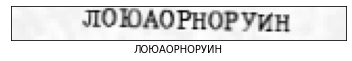

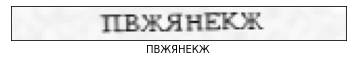

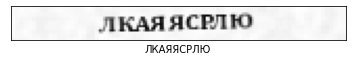

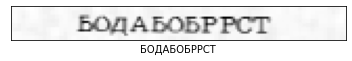

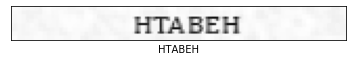

In [ ]:
for i in range(5):
    plt.imshow(255 - data[-1 - i], cmap='gray', vmax=255, vmin=0)
    plt.xlabel(labels[-1 - i])
    plt.xticks([]), plt.yticks([])
    plt.show()

## Preprocessing

### Input

In [ ]:
input_data = data[..., None].astype(np.float32) / 255

### Labels

In [ ]:
## Label conversion tables
# char -> integer id
class_ids = pd.Series(
    range(N_CLASSES),
    index=list(CLASS_NAMES))

# char -> one-hot vector
class_one_hot = pd.Series(
    list(np.identity(N_CLASSES, dtype=np.uint8)),
    index=list(CLASS_NAMES))

# integer id -> char
ids_class = np.array(list(CLASS_NAMES))

class_one_hot[:3]

-    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
А    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Б    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
dtype: object

In [ ]:
#@title { form-width: "1px" }
#@markdown ```python
#@markdown class LabelEncoder()
#@markdown ```
class LabelEncoder:
    def __init__(self):
        self.class_ids = pd.Series(range(N_CLASSES),
                                   index=list(CLASS_NAMES))
        
    def encode(self, text_labels):
        """
        Batch of text labels to k-hot vector representation. Single string will be forced to batch size=1.
        
        'ФЫВГЗАЗДЛЕЯА' -> [[0 0 .. 0 1 0 .. 0 1 0 .. 0]] (size=(batch, N_CLASSES*OUTPUT_MAX_CHARS))
        """
        if type(text_labels) is str:
            text_labels = [text_labels]
        batch_size = len(text_labels)
        batch = np.empty((batch_size, N_CLASSES * OUTPUT_MAX_CHARS), dtype=np.uint8)
        for i, text_label in enumerate(text_labels):
            # 'ФЫВГЗАЗД' -> [Ф, Ы, В, Г, З, А, З, Д, -, -, -, -, -]
            chars = list(text_label.ljust(OUTPUT_MAX_CHARS, '-'))
            batch[i] = np.concatenate(class_one_hot[chars])
        return batch
    
    
    def encode_last_char(self, text_labels):
        """
        Batch of text labels to 1-hot vector representation. Single string will be forced to batch size=1.
        
        'ФЫВГЗАЗДЛЕЯА' -> [[0 0 .. 0 1 0 .. 0]] (size=(batch, N_CLASSES))
        """
        if type(text_labels) is str:
            text_labels = [text_labels]
        batch_size = len(text_labels)
        batch = np.empty((batch_size, N_CLASSES), dtype=np.uint8)
        for i, text_label in enumerate(text_labels):
            # 'ФЫВГЗАЗД' -> [Ф, Ы, В, Г, З, А, З, Д, -, -, -, -, -]
            batch[i] = class_one_hot[text_label[-1]]
        return batch


    def encode_nth_char(self, text_labels, n):
        """
        Batch of text labels to 1-hot vector representation. Single string will be forced to batch size=1.
        
        'ФЫВГЗАЗДЛЕЯА' -> [[0 0 .. 0 1 0 .. 0]] (size=(batch, N_CLASSES))
        """
        if type(text_labels) is str:
            text_labels = [text_labels]
        batch_size = len(text_labels)
        batch = np.empty((batch_size, N_CLASSES), dtype=np.uint8)
        for i, text_label in enumerate(text_labels):
            # 'ФЫВГЗАЗД' -> [Ф, Ы, В, Г, З, А, З, Д, -, -, -, -, -]
            char = text_label[n] if n < len(text_label) else '-'
            batch[i] = class_one_hot[char]
        return batch

    
    def encode_first_char(self, text_labels):
        """
        Batch of text labels to 1-hot vector representation. Single string will be forced to batch size=1.
        
        'ФЫВГЗАЗДЛЕЯА' -> [[0 0 .. 0 1 0 .. 0]] (size=(batch, N_CLASSES))
        """
        if type(text_labels) is str:
            text_labels = [text_labels]
        batch_size = len(text_labels)
        batch = np.empty((batch_size, N_CLASSES), dtype=np.uint8)
        for i, text_label in enumerate(text_labels):
            # 'ФЫВГЗАЗД' -> [Ф, Ы, В, Г, З, А, З, Д, -, -, -, -, -]
            batch[i] = class_one_hot[text_label[0]]
        return batch


    def encode_text_len(self, text_labels):
        """
        Batch of text labels to 1-hot vector representation. Single string will be forced to batch size=1.
        
        'ФЫВГЗАЗДЛЕЯА' -> [[0 0 .. 0 1 0 .. 0]] (size=(batch, N_CLASSES))
        """
        if type(text_labels) is str:
            text_labels = [text_labels]
        batch_size = len(text_labels)
        # 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 (10 classes), min=4, max=13
        batch = np.empty((batch_size,), dtype=np.uint8)
        for i, text_label in enumerate(text_labels):
            # 'ФЫВГЗАЗД' -> [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
            batch[i] = len(text_label) - 4  # min=0, max=9
        return batch

    
    def decode(self, k_hot_labels):
        """ Batch of k-hot labels (2d) to array of strings (1d). """
        words = np.reshape(k_hot_labels, (-1, OUTPUT_MAX_CHARS, N_CLASSES)).argmax(axis=-1)
        labels = []
        for ids in words:
            chars = ids_class[ids]
            word = ''.join(chars).strip('-')
            labels.append(word)
        return np.array(labels)


    def decode_one_hot(self, one_hot_labels):
        """ Batch of 1-hot labels (2d) to array of chars (1d). """
        char_ids = np.argmax(one_hot_labels, axis=-1)
        return ids_class[char_ids]


    def decode_text_len(self, one_hot_labels):
        """ Batch of 1-hot labels (2d) to array of integers (1d). """
        return np.argmax(one_hot_labels, axis=1) + 4


label_encoder = LabelEncoder()

# Tests
test_out = label_encoder.encode(['ФЫВГ', 'ДЛЕЯА'])
assert test_out.shape == (2, 13 * 32)
assert test_out.sum() == 13 * 2

In [ ]:
labels_word_len = label_encoder.encode_text_len(labels)
(labels[0], labels_word_len[0]), (labels[-1], labels_word_len[-1])

(('ИТУНААОРАМО', 7), ('ЛОЮАОРНОРУИН', 8))

In [ ]:
balanced_idx = np.concatenate([np.where(labels_word_len == i)[0][:5000] for i in range(10)])
random.shuffle(balanced_idx)

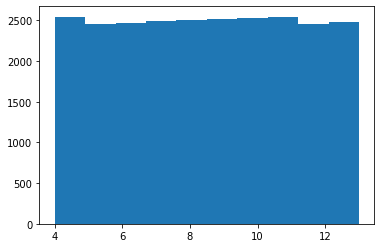

In [ ]:
plt.hist(labels_word_len[balanced_idx[:25000]] + 4, bins=10);

## Train test split

try
1. input mean=0
2. conv+bn+relu+pool

In [ ]:
def print_train_test_info(x_train, x_test):
    template = '{}: {}, {}, min={:.3f}, max={:.3f}, avg={:.3f}, std={:.3f}'
    print(template.format('x_train', x_train.shape, x_train.dtype,
        x_train.min(), x_train.max(), x_train.mean(), x_train.std()))
    print(template.format('x_test ', x_test.shape, x_test.dtype,
        x_test.min(), x_test.max(), x_test.mean(), x_test.std()))

In [ ]:
x_train, x_test = input_data[balanced_idx][:40000],  input_data[balanced_idx][40000:]
print_train_test_info(x_train, x_test)

x_train: (40000, 16, 160, 1), float32, min=0.000, max=1.000, avg=0.111, std=0.205
x_test : (10000, 16, 160, 1), float32, min=0.000, max=1.000, avg=0.111, std=0.204


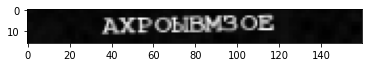

In [ ]:
plt.imshow(x_train[7, ..., 0], cmap='gray', vmin=0, vmax=1)

In [ ]:
y_train, y_test = labels_word_len[balanced_idx][:40000], labels_word_len[balanced_idx][40000:]
print_train_test_info(y_train, y_test)

x_train: (40000,), uint8, min=0.000, max=9.000, avg=4.504, std=2.869
x_test : (10000,), uint8, min=0.000, max=9.000, avg=4.485, std=2.884


In [ ]:
y_train[7] + 4

10

## Model design

In [ ]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='val')
    ax1.set_title('Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(loc='upper left')

    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='val')
    ax2.set_title('Accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc='upper left')

In [ ]:
import tensorflow.keras.layers as KL

conv_params = dict(kernel_initializer='he_normal')

In [ ]:
#@title { form-width: "1px" }
#@markdown ```python
#@markdown model_lg
#@markdown ```
if 0:
    model_lg = tf.keras.Sequential([
        KL.InputLayer(input_shape=(16, 160, 1)),
        KL.Conv2D(64, 3, padding='same', **conv_params),
        KL.BatchNormalization(),
        KL.ReLU(),
        KL.MaxPool2D((2, 2)),  # [None, 8, 80, 64]

        KL.Conv2D(128, 3, padding='same', **conv_params),
        KL.BatchNormalization(),
        KL.ReLU(),
        KL.MaxPool2D((2, 2)),  # [None, 4, 40, 128]

        KL.Conv2D(256, 3, padding='same', **conv_params),
        KL.BatchNormalization(),
        KL.ReLU(),
        KL.Conv2D(256, 3, padding='same', **conv_params),
        KL.BatchNormalization(),
        KL.ReLU(),
        KL.MaxPool2D((2, 2)), # [None, 4, 20, 256]

        KL.Conv2D(512, 3, padding='same', **conv_params),
        KL.BatchNormalization(),
        KL.ReLU(),
        KL.Conv2D(512, 3, padding='same', **conv_params),
        KL.BatchNormalization(),
        KL.ReLU(),
        KL.MaxPool2D((2, 2)),  # [None, 4, 10, 512]

        KL.Conv2D(512, 3, padding='same', **conv_params),
        KL.BatchNormalization(),
        KL.ReLU(),

        KL.Flatten(),  # 5120
        KL.Dense(512, activation='relu'),
        KL.Dense(256, activation='relu'),
        KL.Dense(32, activation='softmax'),
    ])

    print(f'Model size: {model_lg.count_params() * 4 / 10**6:.1f}MB')

    model_lg(np.empty((64, 16, 160, 1), dtype=np.float32)).shape

In [ ]:
from locale import CHAR_MAX
#@title { form-width: "1px" }
#@markdown ```python
#@markdown model
#@markdown ```
model = tf.keras.Sequential([
    KL.InputLayer(input_shape=(16, 160, 1)),
    KL.Conv2D(32, 3, padding='same', **conv_params),
    KL.BatchNormalization(),
    KL.ReLU(),
    KL.MaxPool2D((2, 2)),  # [None, 8, 80, 32]

    KL.Conv2D(64, 3, padding='same', **conv_params),
    KL.BatchNormalization(),
    KL.ReLU(),
    KL.MaxPool2D((2, 2)),  # [None, 4, 40, 64]

    KL.Conv2D(128, 3, padding='same', **conv_params),
    KL.BatchNormalization(),
    KL.ReLU(),
    KL.MaxPool2D((2, 2)), # [None, 4, 20, 128]

    KL.Conv2D(256, 3, padding='same', **conv_params),
    KL.BatchNormalization(),
    KL.ReLU(),
    KL.Conv2D(256, 3, padding='same', **conv_params),
    KL.BatchNormalization(),
    KL.ReLU(),
    KL.MaxPool2D((2, 2)),  # [None, 4, 10, 256]

    KL.Flatten(),  # 2560
    KL.Dense(256, activation='relu'),
    KL.Dense(10),
])

print(f'Model size: {model.count_params() * 4 / 10**6:.1f}MB')

model(np.empty((64, 16, 160, 1), dtype=np.float32)).shape

Model size: 6.6MB


TensorShape([64, 10])

In [ ]:
model.compile(
    # optimizer=tf.keras.optimizers.Adam(),
    optimizer=tf.keras.optimizers.Adadelta(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics='accuracy'
)

In [ ]:
test_out = model(x_train[:64])
print(test_out.shape, test_out[0][:5])

(64, 10) tf.Tensor([-0.60278845 -0.36268055  0.0221276   0.655241   -0.00121999], shape=(5,), dtype=float32)


In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
625/625 [==============================] - 8s 13ms/step - loss: 0.0502 - accuracy: 0.9827 - val_loss: 0.0271 - val_accuracy: 0.9937
Epoch 2/10
625/625 [==============================] - 9s 14ms/step - loss: 0.0503 - accuracy: 0.9840 - val_loss: 0.0244 - val_accuracy: 0.9951
Epoch 3/10
625/625 [==============================] - 8s 13ms/step - loss: 0.0448 - accuracy: 0.9853 - val_loss: 0.0239 - val_accuracy: 0.9954
Epoch 4/10
625/625 [==============================] - 9s 15ms/step - loss: 0.0441 - accuracy: 0.9861 - val_loss: 0.0236 - val_accuracy: 0.9954
Epoch 5/10
625/625 [==============================] - 9s 14ms/step - loss: 0.0446 - accuracy: 0.9858 - val_loss: 0.0229 - val_accuracy: 0.9956
Epoch 6/10
625/625 [==============================] - 9s 14ms/step - loss: 0.0437 - accuracy: 0.9864 - val_loss: 0.0225 - val_accuracy: 0.9959
Epoch 7/10
625/625 [==============================] - 8s 13ms/step - loss: 0.0467 - accuracy: 0.9847 - val_loss: 0.0225 - val_accuracy: 0.9958

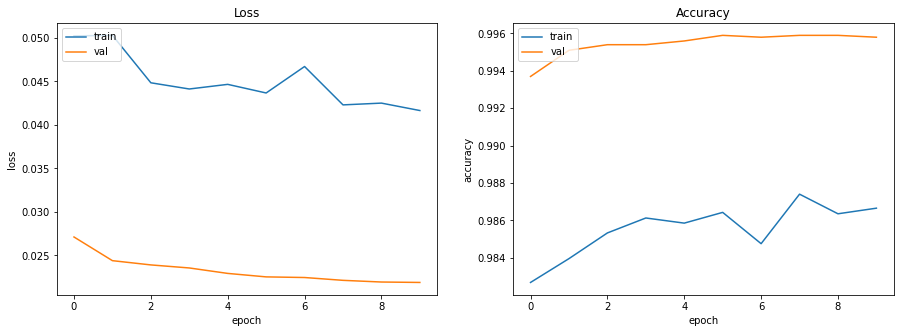

In [ ]:
plot_history(history)

In [ ]:
model.save('model_text_len')

In [ ]:
!zip -r model_text_len model_text_len

  adding: model_text_len/ (stored 0%)
  adding: model_text_len/keras_metadata.pb (deflated 94%)
  adding: model_text_len/variables/ (stored 0%)
  adding: model_text_len/variables/variables.data-00000-of-00001 (deflated 25%)
  adding: model_text_len/variables/variables.index (deflated 73%)
  adding: model_text_len/assets/ (stored 0%)
  adding: model_text_len/saved_model.pb (deflated 90%)


In [ ]:
!cp model_text_len.zip drive/MyDrive/ml-data/ocr-dataset/

In [ ]:
!ls -lah drive/MyDrive/ml-data/ocr-dataset/

total 183M
drwx------ 2 root root 4.0K Dec  3 10:06 .ipynb_checkpoints
-rw------- 1 root root  14M Dec  3 15:28 model_char0.zip
-rw------- 1 root root  14M Dec  3 15:47 model_char1.zip
-rw------- 1 root root  14M Dec  3 15:56 model_char2.zip
-rw------- 1 root root  14M Dec  3 16:41 model_char3.zip
-rw------- 1 root root  14M Dec  3 16:57 model_char4.zip
-rw------- 1 root root  15M Dec  3 18:58 model_text_len.zip
-rw------- 1 root root 103M Dec  3 10:49 words-dataset-100k.npz


In [ ]:
model_loaded = tf.keras.models.load_model('model_text_len')
out = model_loaded(x_test[-10:])
label_encoder.decode_text_len(out)[::-1]

array([13,  8,  7, 12,  5,  7,  4, 13, 12, 12])

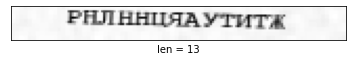

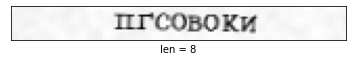

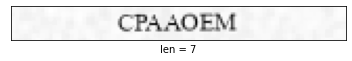

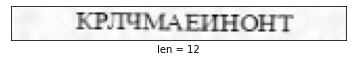

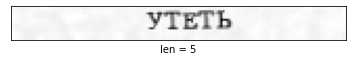

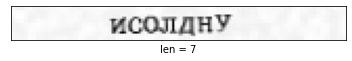

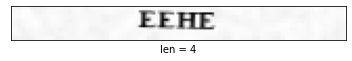

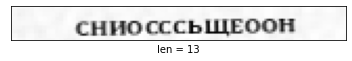

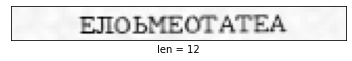

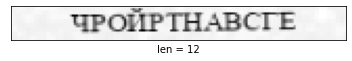

In [ ]:
for i in range(10):
    plt.imshow(1 - x_test[-1 - i, ..., 0], cmap='gray', vmin=0, vmax=1)
    plt.xlabel('len = %d' % (y_test[-1 - i] + 4))
    plt.xticks([]), plt.yticks([])
    plt.show()

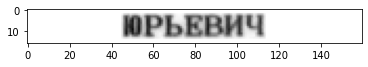

In [ ]:
# Custom image test

import cv2
import imutils
img = cv2.imread('1.png', cv2.IMREAD_GRAYSCALE)
img = cv2.normalize(img,  None, 0, 255, cv2.NORM_MINMAX)
img = imutils.resize(img, height=12)

blank = np.zeros((16, 160), dtype=np.uint8)

h, w = img.shape
x, y = (160 - w) // 2, (16 - h) // 2

blank[y : y + h, x : x + w] = 255 - img
img = blank
plt.imshow(255 - img, cmap='gray', vmin=0, vmax=255)

In [ ]:
batch = (img / 255)[None, ..., None]
batch_pred = model(batch)
np.argmax(batch_pred[0]) + 4

7